In [1]:
import torch 
import torchvision 
from torch import nn
from torchvision import transforms

import matplotlib.pyplot as plt

In [39]:
# import some custom functions (have already written and tested) 
import os 
import sys


parent_dir = os.path.abspath(os.path.join(os.getcwd(),os.pardir))
sys.path.append(parent_dir)

from  pytorch_deep_learning.going_modular.going_modular import data_setup, engine, predictions
from  pytorch_deep_learning import helper_functions

sys.path.remove(parent_dir)

In [3]:
# setup device agnostic code 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# download data 
from helper_functions import download_data, set_seeds, plot_loss_curves
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
# setup the directory paths to train and test images 
train_dir = image_path/'train'
test_dir = image_path/'test'

In [6]:
# create data sets and data loaders 
IMG_SIZE = 224
manual_transform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.ToTensor()])

In [7]:
# turn images into dataloaders 
BATCH_SIZE = 32 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, 
                                                                               transform=manual_transform, batch_size = BATCH_SIZE)

In [8]:
# visualize an image 
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]

(-0.5, 223.5, 223.5, -0.5)

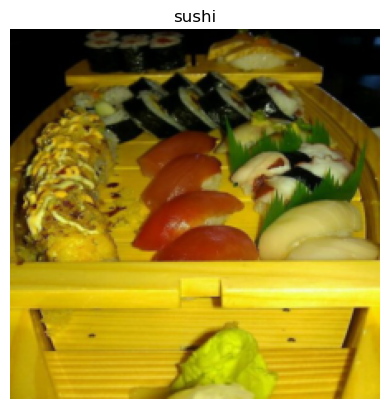

In [9]:
# plot test image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [10]:
image.shape

torch.Size([3, 224, 224])

In [11]:
# creating image patches: size of patch = 16 
# N = [224*224]/[16*16] -> [14*14]
# input: [1,3,224,224] -> output: [1,768,14,14] 

patch_size = 16 

conv2d = nn.Conv2d(in_channels=3,out_channels=768,kernel_size=patch_size,stride=patch_size,padding=0)
image_out_of_conv = conv2d(image.unsqueeze(0))
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [12]:
# create flatten layer
flatten = nn.Flatten(start_dim=2,end_dim=3)
image_out_of_conv_flatten = flatten(image_out_of_conv)
image_out_of_conv_flatten.shape

torch.Size([1, 768, 196])

In [13]:
# patch embedding layer

class PatchEmbeddig(nn.Module):
    def __init__(self,in_channels:int=3,path_size:int=16,embedding_dim :int=768):
        super().__init__()
        # layer to convert image into patches 
        self.patcher = nn.Conv2d(in_channels=in_channels,out_channels=embedding_dim,
                                 kernel_size=patch_size,stride=path_size,padding=0)
        # flatten the patches 
        self.flatten = nn.Flatten(start_dim=2,end_dim=3)
        
    def forward(self,x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0,f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0,2,1) # now the embedding on the last dim 

In [14]:
set_seeds()
patchify = PatchEmbeddig(in_channels=3,path_size=16,embedding_dim=768)

# pass a single image through 
print(f"input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"output patch embedding shape:{patch_embedded_image.shape}")

input image shape: torch.Size([1, 3, 224, 224])
output patch embedding shape:torch.Size([1, 196, 768])


In [15]:
# creating class token embedding [B,1,embedding_dim=768]

# 1. Get the batch size and embedding dimension 
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# 2. Create class token (the last dim is same as for patch embedding dim)
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension,requires_grad=True))

In [16]:
# 3. add the class embedding to patch embedding layer 
patch_embedded_image_with_class_embedding = torch.cat((class_token,patch_embedded_image),dim=1)
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [17]:
# positional embedding : positional embeddings are added to patch embedding to retain positional info

number_of_positions = patch_embedded_image_with_class_embedding.shape[1]
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

positional_embedding = nn.Parameter(torch.ones(1,number_of_positions,embedding_dimension,requires_grad=True))
positional_embedding.shape

torch.Size([1, 197, 768])

In [18]:
# patch and positional embedding 
patch_and_positional_embedding = patch_embedded_image_with_class_embedding + positional_embedding
patch_and_positional_embedding.shape

torch.Size([1, 197, 768])

In [19]:
# build the multihead attention layer (+ layer normalization)

class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim:int=768,num_heads:int=12, attn_dropout:float=0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim) # layer norm 
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,num_heads=num_heads, # MSA layer 
                                                    dropout=attn_dropout,batch_first=True)
        
    def forward(self,x):
        x = self.layer_norm(x)
        atten_output,_ = self.multihead_attn(query=x,key=x,value=x,need_weights=False)
        return atten_output

In [20]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768,num_heads=12)
patched_image_through_msa_block = multihead_self_attention_block(patch_and_positional_embedding)
patched_image_through_msa_block.shape

torch.Size([1, 197, 768])

In [21]:
# build MLP layer 
class MLPBlock(nn.Module):
    def __init__(self,embedding_dim:int=768,mlp_size:int=3072,dropout:float=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(nn.Linear(in_features=embedding_dim,out_features=mlp_size),
                                 nn.GELU(),
                                 nn.Dropout(p=dropout),
                                 nn.Linear(in_features=mlp_size,out_features=embedding_dim),
                                 nn.Dropout(p=dropout))
    def forward(self,x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x 

In [22]:
# create MLP block and pass data through it 
mlp_block = MLPBlock(embedding_dim=768,mlp_size=3072,dropout=0.1)
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
patched_image_through_msa_block.shape

torch.Size([1, 197, 768])

In [23]:
# transformer encoder block 
class TransformerEncoderBlock(nn.Module):
    def __init__(self,embedding_dim:int=768,num_heads:int=12,mlp_size:int=3072,mlp_dropout:float=0.1,attn_dropout: float=0):
        super().__init__()
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,num_heads=num_heads,attn_dropout=attn_dropout)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,mlp_size=mlp_size,dropout=mlp_dropout)
        
    def forward(self,x):
        x = self.msa_block(x) + x 
        x = self.mlp_block(x) + x 
        return x 

In [24]:
TransformerEncoderBlock()

TransformerEncoderBlock(
  (msa_block): MultiheadSelfAttentionBlock(
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
  )
  (mlp_block): MLPBlock(
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU(approximate='none')
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=3072, out_features=768, bias=True)
      (4): Dropout(p=0.1, inplace=False)
    )
  )
)

In [25]:
# create vision transformer class:using all the classes (and fucntions) that we have created so far 
class ViT(nn.Module):
    def __init__(self, img_size:int=224,     # input image resolution 
                 in_channel:int=3,           # number of channels in the image
                 patch_size:int=16,          # patch size 
                 num_transformer_layers:int =16,# number of transfomer layers 
                 embedding_dim:int=768,      # embedding dimension for patch and positional embedding 
                 mlp_size:int = 3072,        # mlp hidden layer size 
                 num_heads:int=12,           # muber of attention heads 
                 atten_dropout:float=0,      # dropout for attention layer 
                 mlp_dropout:float=0.1,      # droput for dense/MLP layer 
                 embedding_dropout:float=0.1,# dropout for patch and positional embedding 
                 num_classes:int=1000):      # default value for ImageNet (it can classify 1000 items: but we can modify this)
        
        super().__init__()
        # check image is divisible by patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        # number of patches per image 
        self.num_patches = (img_size**2)//(patch_size**2)
        # create learnable class embedding 
        self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim),requires_grad=True)
        # create learnable positional embedding 
        self.positional_embedding = nn.Parameter(data=torch.randn(1,self.num_patches +1, embedding_dim),requires_grad=True)
        # create embedding dropout layer 
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        # create patch embedding layer 
        self.patch_embedding = PatchEmbeddig(in_channels=in_channel,path_size=patch_size,embedding_dim=embedding_dim)
        # create trasnfomer embedding layer 
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,num_heads=num_heads,mlp_size=mlp_size,
                                                                          mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        # classifier head 
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                        nn.Linear(in_features=embedding_dim,out_features=num_classes))
        
    def forward(self,x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size,-1,-1) # (B,1,embedding_dim)
        x = self.patch_embedding(x)                                 # (1,num_patches,embedding_dim)
        x = torch.cat((class_token,x),dim =1)                       # (B,num_patches + 1,embedding_dim)->broadcasting in action 
        x = self.positional_embedding + x                           # (1,num_patches + 1,embedding_dim) + (B,num_patches + 1,embedding_dim)
        x = self.embedding_dropout(x)                               # (B,num_patches + 1,embedding_dim)
        x = self.transformer_encoder(x)                             # (B,num_patches + 1,embedding_dim)
        x = self.classifier(x[:,0])                                 # (B,1,num_classes)
        return x 

In [26]:
set_seeds()

random_image_tensor = torch.randn(1,3,224,224)
vit = ViT(num_classes=len(class_names))
vit(random_image_tensor)

tensor([[-0.1092, -0.8746, -0.1502]], grad_fn=<AddmmBackward0>)

In [27]:
device

'cuda'

In [28]:
# train the model -> results are not good[as we used small amout of data to train big model ]
# model probably underfitting the data 

from going_modular import engine
# optimizer 
optimizer = torch.optim.Adam(params=vit.parameters(),lr=3e-3,betas=(0.9,0.999),weight_decay=0.3)
# loss function 
loss_fn = torch.nn.CrossEntropyLoss()
# set seed 
set_seeds()
vit = vit.to(device)
# train the model 
results = engine.train(model=vit,train_dataloader=train_dataloader,test_dataloader=test_dataloader,
                       optimizer=optimizer,loss_fn=loss_fn,epochs=10,device=device)


Epoch: 1 | train_loss: 3.3947 | train_acc: 0.2734 | test_loss: 2.6561 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.7795 | train_acc: 0.4336 | test_loss: 2.6008 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.3763 | train_acc: 0.2852 | test_loss: 1.6919 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2361 | train_acc: 0.2969 | test_loss: 1.3047 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1275 | train_acc: 0.3086 | test_loss: 1.1781 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1623 | train_acc: 0.2930 | test_loss: 1.2586 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2670 | train_acc: 0.2617 | test_loss: 1.1557 | test_acc: 0.2604
Epoch: 8 | train_loss: 1.1234 | train_acc: 0.2773 | test_loss: 1.1886 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1586 | train_acc: 0.4297 | test_loss: 1.0270 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2879 | train_acc: 0.2695 | test_loss: 1.5124 | test_acc: 0.2604


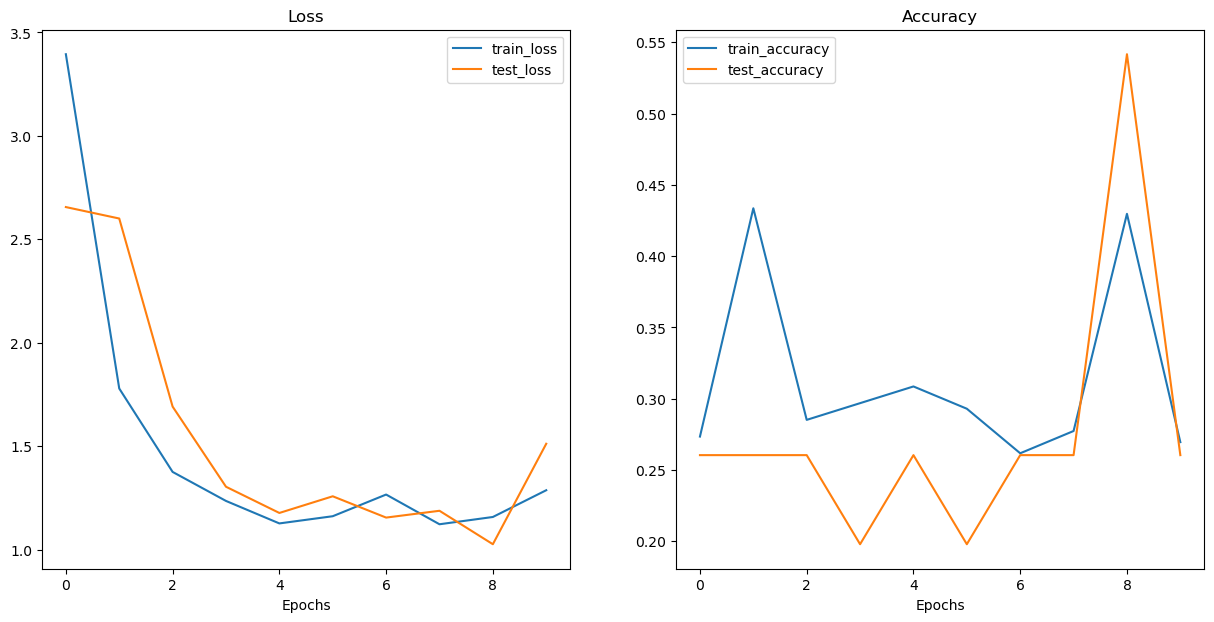

In [29]:
# plot the loss curves 
from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [31]:
# let's use pre-trined viT model (with slight modification on the classifier head) on our data 

# 1. get the pre-trained weights for ViT base 
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. setup ViT model instance with pre-trained weights 
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters 
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False 
    
# 4. change the classifier head 
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /home/amara/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:31<00:00, 11.1MB/s] 


In [32]:
# get automatic trasnforms from pretrained ViT weights 
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [33]:
# setup data loaders 
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir,
                                                                                                     transform = pretrained_vit_transforms,batch_size =32 )

In [34]:
# train feature extractor ViT model 

# 1. optimzer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# 2. train the model 
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,optimizer=optimizer,loss_fn=loss_fn,epochs=10, device=device)

Epoch: 1 | train_loss: 0.7369 | train_acc: 0.7305 | test_loss: 0.4714 | test_acc: 0.8883
Epoch: 2 | train_loss: 0.3181 | train_acc: 0.9648 | test_loss: 0.2969 | test_acc: 0.9384
Epoch: 3 | train_loss: 0.1849 | train_acc: 0.9688 | test_loss: 0.2502 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1384 | train_acc: 0.9727 | test_loss: 0.2233 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.1106 | train_acc: 0.9727 | test_loss: 0.2120 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.1152 | train_acc: 0.9766 | test_loss: 0.2045 | test_acc: 0.9384
Epoch: 7 | train_loss: 0.0837 | train_acc: 0.9805 | test_loss: 0.2358 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0719 | train_acc: 0.9883 | test_loss: 0.2281 | test_acc: 0.8883
Epoch: 9 | train_loss: 0.1007 | train_acc: 0.9883 | test_loss: 0.2032 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0581 | train_acc: 0.9922 | test_loss: 0.1770 | test_acc: 0.9479


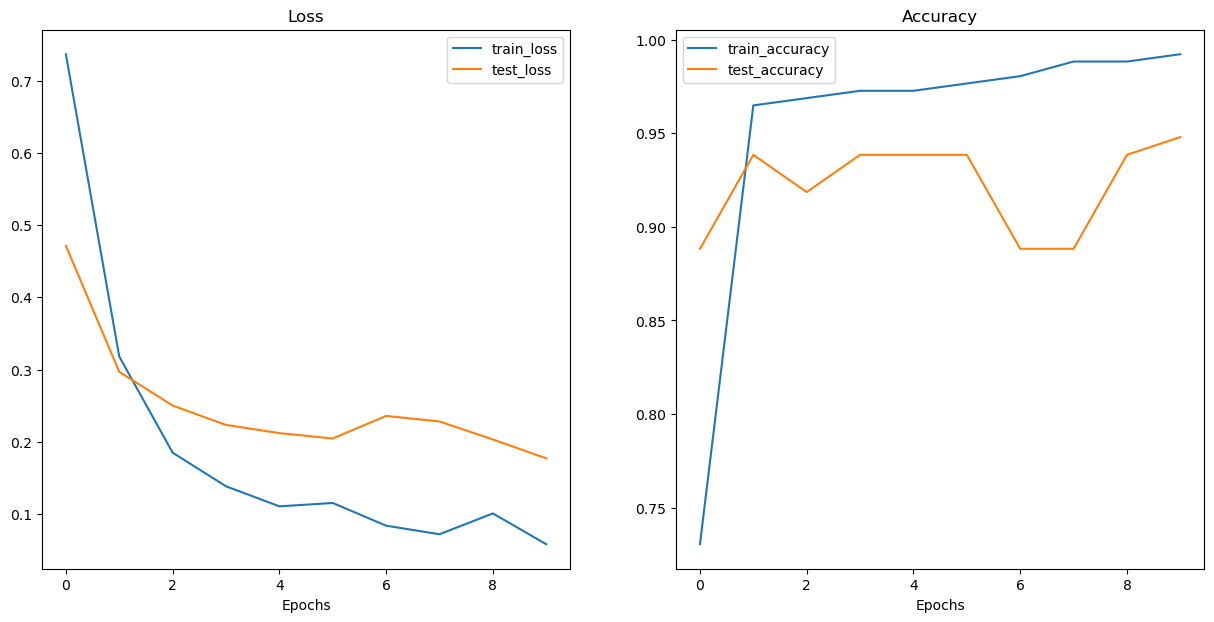

In [35]:
# plot the loss curves -> you can see huge improvement to both loss and accuracy 
plot_loss_curves(pretrained_vit_results)

In [36]:
# save the model 
from going_modular import utils
utils.save_model(model=pretrained_vit,target_dir="models",model_name="vit_feature_extractor_for_pizza_steak_sushi.pth")

[INFO] saving model to: models/vit_feature_extractor_for_pizza_steak_sushi.pth


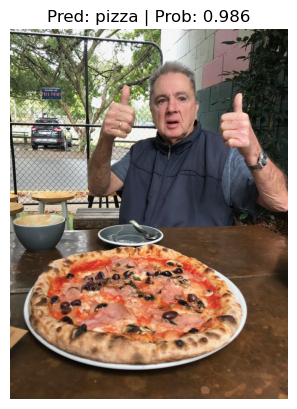

In [45]:
# make prediction on custom image (not in the train or test data set)

from pathlib import Path 
data_path = Path('DATA')
custom_image_path = data_path/"04-pizza-dad.jpeg"

from going_modular.predictions import pred_and_plot_image
pred_and_plot_image(model=pretrained_vit,image_path=custom_image_path,class_names=class_names)